## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show plots inline (no interactive separate window)
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

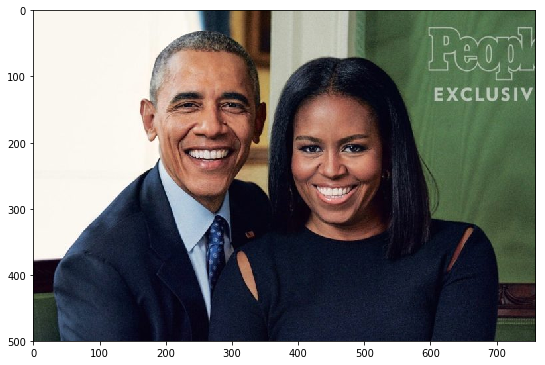

In [2]:
import cv2
# load in an RGB color image for face detection
#test_image = cv2.imread('images/mona_lisa.jpg')
test_image = cv2.imread('images/obamas.jpg')
#test_image = cv2.imread('images/the_beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# plot the test image
fig = plt.figure(figsize=(9,9))
plt.imshow(test_image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


In [3]:
# detect regions of interest proposals with human faces in a given RGB color image
def detect_faces(image):
    '''
    Detects human faces in an RGB color image using openCV2's haar cascade classifier 
    and returns a list of bounding boxes for all detected faces in the image.
    input arguments:
        image: RGB color image
    output arguments:
        faces: a list of face detections with bounding boxes of format (upper left corner 
               (x, y), width w and heigh h)
    '''
    
    # load in a haar cascade classifier for detecting frontal faces
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
    
    # run the detector
    # the output here is an array of detections; the corners of each detection box
    # if necessary, modify these parameters until you successfully identify every face in a given image
    faces = face_cascade.detectMultiScale(image, 1.2, 2)
    
    # make a copy of the original image to plot detections on
    image_with_detections = image.copy()
    
    # loop over the detected faces, mark the image where each face is found
    for (x,y,w,h) in faces:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3)
    
    fig = plt.figure(figsize=(9,9))
    
    plt.imshow(image_with_detections)
    
    # return image with face bounding box detections
    return image_with_detections, faces

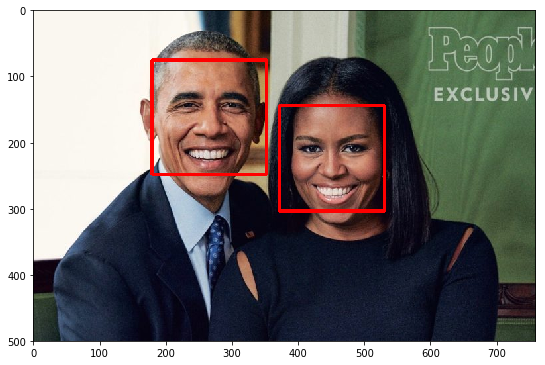

In [4]:
# Detect face bouding boxes in the given test image
test_image_with_detections, faces = detect_faces(test_image)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [5]:
import torch

# Select net model no. to be imported
NET_MODEL_NO = 3
if NET_MODEL_NO == 0:
    from models_0 import Net
elif NET_MODEL_NO == 1:
    from models_1 import Net
elif NET_MODEL_NO == 2:
    from models_2 import Net
else:
    from models_3 import Net # Recommendation: Use net model no. 3 => It seems to have the best performance

# initialize Net model structure
net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model

# set model directory
model_dir = 'saved_models/'

# set model name
if NET_MODEL_NO == 0:
    # model name for model 0 and minimum validation loss
    model_name_min_loss = 'keypoints_model_0_min_loss.pt'
    # model name for model 0 and last state after training
    model_name_last_state = 'keypoints_model_0_last_state.pt'
elif NET_MODEL_NO == 1:
    # model name for model 1 and minimum validation loss
    model_name_min_loss = 'keypoints_model_1_min_loss.pt'
    # model name for model 1 and last state after training
    model_name_last_state = 'keypoints_model_1_last_state.pt'
elif NET_MODEL_NO == 2:
    # model name for model 2 and minimum validation loss
    model_name_min_loss = 'keypoints_model_2_min_loss.pt'
    # model name for model 2 and last state after training
    model_name_last_state = 'keypoints_model_2_last_state.pt'
else:
    # model name for model 3 and minimum validation loss
    model_name_min_loss = 'keypoints_model_3_min_loss.pt'
    # model name for model 3 and last state after training
    model_name_last_state = 'keypoints_model_3_last_state.pt'

# Chose either the model with minimum validation loss or the model as of last state of trainging
MIN_LOSS = True

if MIN_LOSS:
    # set model path for minimum validation loss
    model_path = model_dir + model_name_min_loss
else:
    # set model path for last state after all training epochs
    model_path = model_dir + model_name_last_state

# load trained model parameters as state dictionary
net.load_state_dict(torch.load(model_path))

# print out your net and prepare it for testing (uncomment the line below)
net.eval() # set net model to evaluation mode => set dropout probability to zero and rescale weights

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop2): Dropout(p=0.15, inplace=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop4): Dropout(p=0.25, inplace=False)
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [6]:
# predict facial keypoints in an image within given region of interest proposals
def predict_facial_keypoints(image, image_with_detections, faces):
    '''
    Detects facial keypoints in a color image within given regions of interests 
    where faces are assumed due to face detections provided by another classifier
    (e. g. a haar cascade).
    input arguments:
        image: RGB color image
        image_with_detections: RGB color image with face bouding boxes added
        faces: list of face detections with bounding boxes of format (upper left 
        corner (x, y), width w and heigh h)
    global variables:
        net: facial keypoint detector model returning 68 facial keypoints
    output arguments:
        key_pts_for_all_faces: list of keypoint lists with 68 facial keypoints per
        list for all face detections given by faces 
    '''
    # make a copy of the sample image
    image_copy = np.copy(image)
    
    # set up the figure for visualization
    fig1 = plt.figure(figsize=(9,9))
    
    # plot image with detections from haar cascade
    ax1 = plt.imshow(image_with_detections)
    plt.title('Predicted facial keypoints within detected regions of interests')
    
    num_faces = len(faces)
    
    fig2 = plt.figure(figsize=(9,9))
    
    # initialize list of predicted facial keypoints for all faces
    key_pts_for_all_faces = []
    
    # loop over the detected faces from your haar cascade
    for idx, (x,y,w,h) in enumerate(faces):
        
        # Select the region of interest that is the face in the image 
        roi_rgb = image_copy[y:y+h, x:x+w]
        
        ## TODO: Convert the face region from RGB to grayscale
        roi_gray = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2GRAY)
        
        ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi_gray = roi_gray / 255.0
        
        ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        roi_gray = cv2.resize(roi_gray, (224, 224))
        
        ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        roi_gray = np.expand_dims(roi_gray, axis=0) # add a color axis as first dim. according to torch format
        # roi_gray = np.expand_dims(roi_gray, axis=2) # expand numpy array dim. by a color axis as third dim.
        # roi_gray = roi_gray.transpose((2, 0, 1)) # transpose axis
        torch_roi_image = torch.from_numpy(roi_gray) #  convert numpy array to torch tensor
        torch_roi_image = torch_roi_image.unsqueeze(0) # add a tensor dimension for the batch size 
        torch_roi_image = torch_roi_image.type(torch.FloatTensor) # convert tensor to float64 format
        
        ## TODO: Make facial keypoint predictions using your loaded, trained network 
        ## perform a forward pass to get the predicted facial keypoints
        with torch.no_grad():
            
            # forward pass to get net output for the given region of interest
            predicted_roi_key_pts = net(torch_roi_image) # predict facial keypoints using net model
        
            # reshape to (batch_size = 1) x 68 x 2 pts
            predicted_roi_key_pts = predicted_roi_key_pts.view(predicted_roi_key_pts.size()[0], 68, -1)
            
            # remove "requires gradients" by detaching and convert to numpy and squeeze
            predicted_roi_key_pts = np.squeeze(predicted_roi_key_pts.detach().numpy())
            # predicted_roi_key_pts = predicted_roi_key_pts.detach()
    
        roi_image = torch_roi_image.numpy()[0] # convert tensor back to numpy array and reduce batch size dimension
        roi_image = np.transpose(roi_image, (1, 2, 0)) # transpose numpy array swapping color channel to the back
        
        # predicted_roi_key_pts = predicted_roi_key_pts[0].data
        # predicted_roi_key_pts = predicted_roi_key_pts.numpy()
        predicted_roi_key_pts = predicted_roi_key_pts * 50.0 + 100
                
        ## TODO: Display each detected face and the corresponding keypoints
        # change color or marker per detected face
        plt.figure(fig2.number) # activate figure 2
        ax = plt.subplot(1, num_faces, idx + 1)
        plt.imshow(np.squeeze(roi_image), cmap='gray')
        plt.scatter(predicted_roi_key_pts[:, 0], predicted_roi_key_pts[:, 1], s=20, marker='.', c='m')
        
        # rescale roi keypoints
        predicted_roi_key_pts = predicted_roi_key_pts * np.array([w / 224, h / 224])
        
        # get keypoints from roi keypoints
        predicted_key_pts = np.array([x, y]) + predicted_roi_key_pts
        
        # attach predicted keypoints for the current face to the list of keypoints for all faces
        key_pts_for_all_faces.append(predicted_key_pts)
        
        # add predicted facial key points to the image with face detections as bounding boxes
        plt.figure(fig1.number) # activate figure 1
        plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
        
    # show plot
    plt.show()
    
    # return list of facial keypoints for all detected faces
    return key_pts_for_all_faces

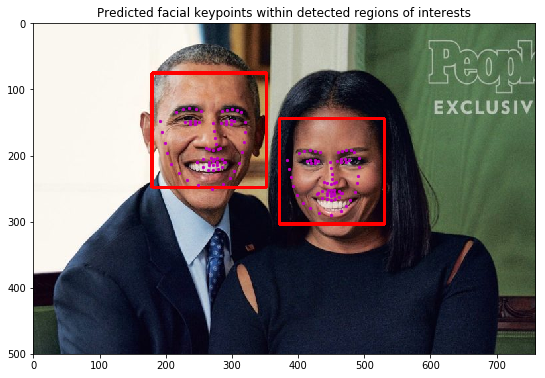

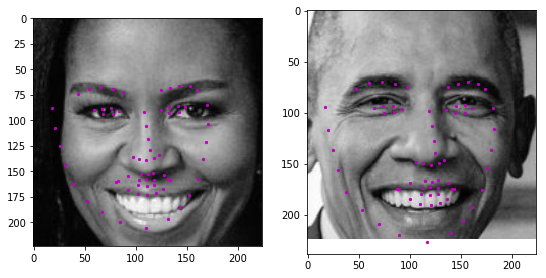

In [7]:
# predict facial keypoints in all proposed face bounding box detections
predicted_key_pts_for_all_faces = predict_facial_keypoints(test_image, test_image_with_detections, faces)

## Test facial keypoint prediction on test dataset

### Compare the predicted keypoints with ground truth keypoints

In [8]:
def show_face_with_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted and ground truth  keypoints (if provided)"""
    # define the figure size
    fig = plt.figure(figsize=(9,9))
    # show image
    plt.imshow(image)
    # plot predicted keypoints as magenta markers
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth keypoints as green markers
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='*', c='g')

Length of test data set: 770


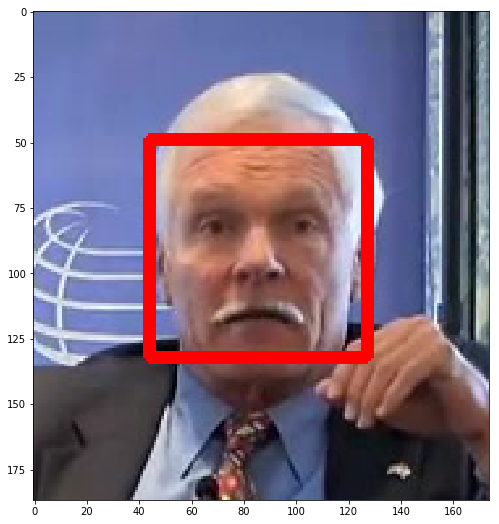

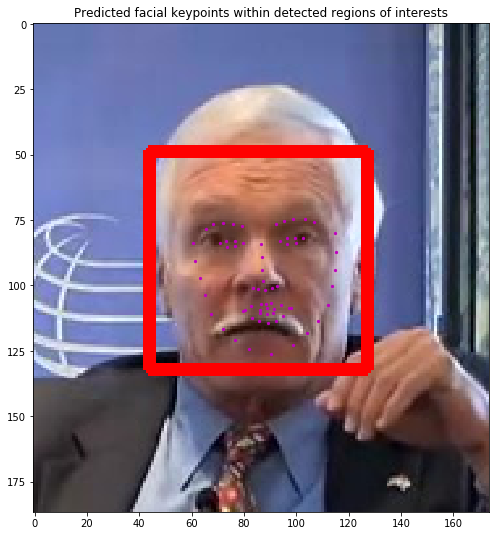

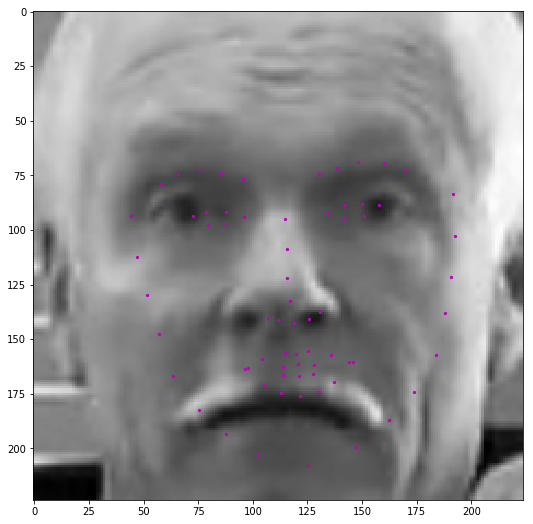


Compare ground truth key points with predicted key points:

Keypoint index       | Ground truth         | Prediction          
0                    | [52.000  , 91.000  ] | [60.347  , 83.676  ]
1                    | [52.000  , 101.000 ] | [61.450  , 90.684  ]
2                    | [54.000  , 109.000 ] | [63.177  , 97.094  ]
3                    | [54.000  , 119.000 ] | [65.111  , 103.657 ]
4                    | [59.000  , 130.000 ] | [67.585  , 110.765 ]
5                    | [64.000  , 135.000 ] | [72.000  , 116.574 ]
6                    | [69.000  , 140.000 ] | [76.423  , 120.692 ]
7                    | [77.000  , 143.000 ] | [81.993  , 124.180 ]
8                    | [90.000  , 143.000 ] | [90.479  , 126.137 ]
9                    | [103.000 , 143.000 ] | [98.638  , 122.902 ]
10                   | [110.000 , 141.000 ] | [104.076 , 118.340 ]
11                   | [115.000 , 136.000 ] | [108.415 , 113.541 ]
12                   | [120.000 , 128.000 ] | [112.047 , 107.305 ]
1

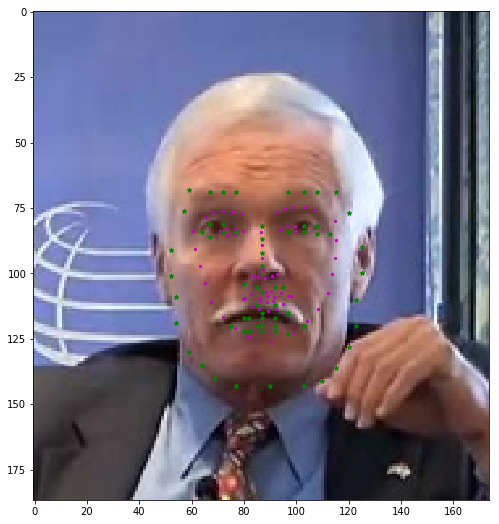

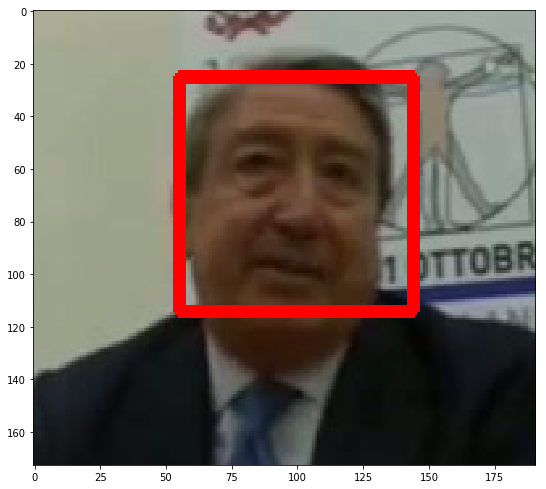

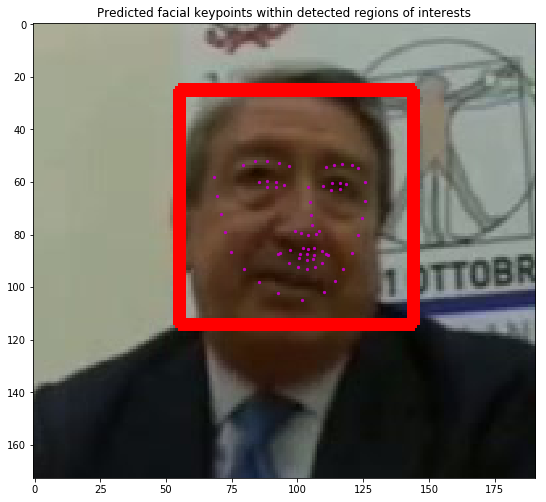

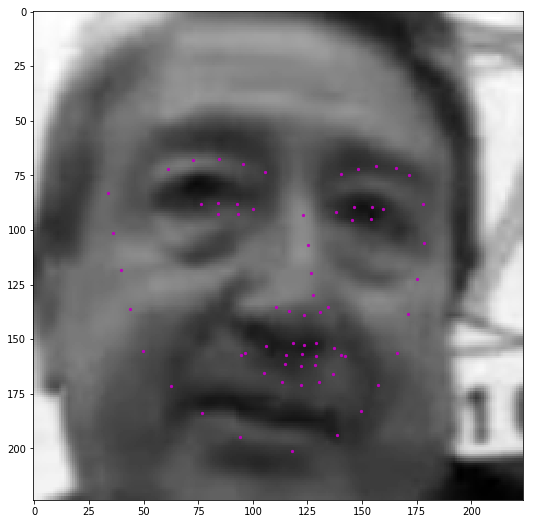


Compare ground truth key points with predicted key points:

Keypoint index       | Ground truth         | Prediction          
0                    | [57.000  , 66.000  ] | [68.340  , 57.937  ]
1                    | [59.000  , 76.000  ] | [69.359  , 65.317  ]
2                    | [59.000  , 86.000  ] | [70.787  , 72.023  ]
3                    | [59.000  , 94.000  ] | [72.322  , 79.029  ]
4                    | [62.000  , 104.000 ] | [74.737  , 86.653  ]
5                    | [67.000  , 112.000 ] | [79.849  , 93.165  ]
6                    | [72.000  , 117.000 ] | [85.524  , 98.046  ]
7                    | [83.000  , 120.000 ] | [92.478  , 102.288 ]
8                    | [95.000  , 125.000 ] | [101.873 , 104.921 ]
9                    | [108.000 , 125.000 ] | [109.966 , 101.975 ]
10                   | [116.000 , 123.000 ] | [114.339 , 97.604  ]
11                   | [121.000 , 120.000 ] | [117.512 , 92.948  ]
12                   | [126.000 , 113.000 ] | [120.917 , 87.042  ]
1

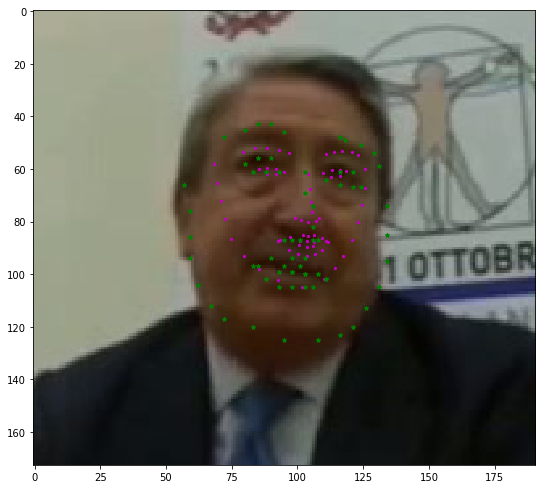

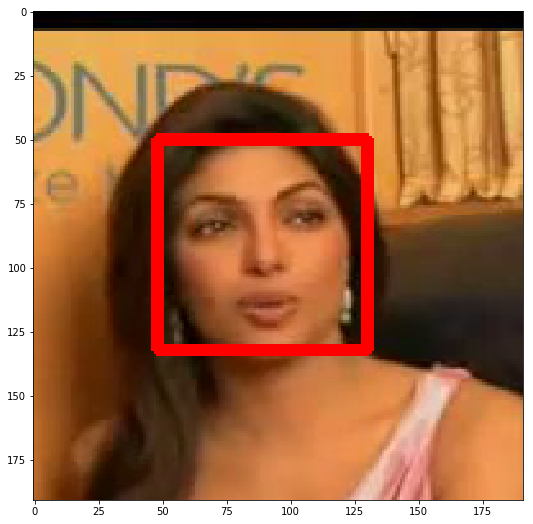

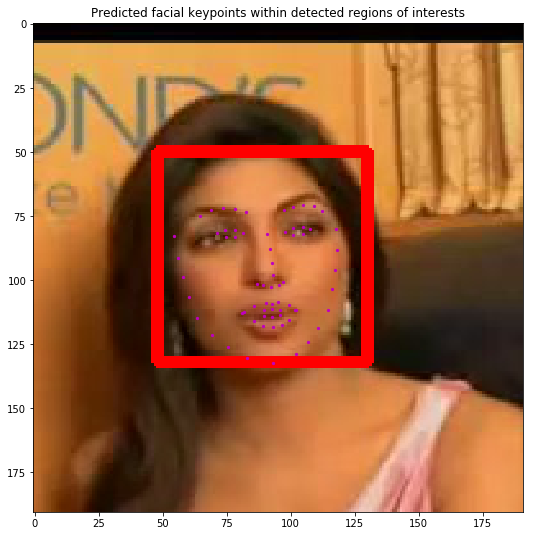

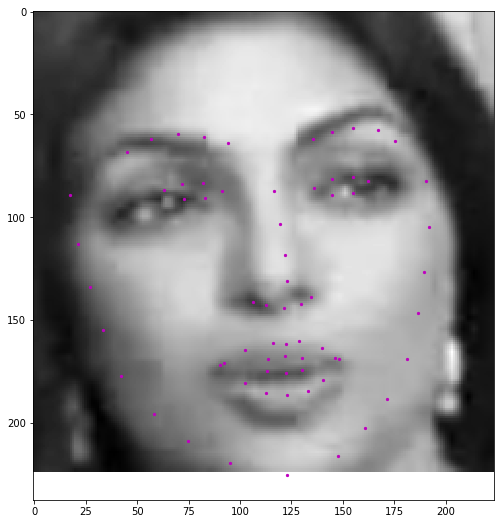


Compare ground truth key points with predicted key points:

Keypoint index       | Ground truth         | Prediction          
0                    | [52.000  , 91.000  ] | [54.443  , 82.668  ]
1                    | [54.000  , 99.000  ] | [55.861  , 91.310  ]
2                    | [56.000  , 108.000 ] | [57.999  , 98.962  ]
3                    | [60.000  , 114.000 ] | [60.203  , 106.597 ]
4                    | [62.000  , 123.000 ] | [63.512  , 114.836 ]
5                    | [69.000  , 129.000 ] | [69.241  , 121.583 ]
6                    | [75.000  , 134.000 ] | [75.349  , 126.310 ]
7                    | [84.000  , 136.000 ] | [82.763  , 130.347 ]
8                    | [94.000  , 138.000 ] | [93.008  , 132.515 ]
9                    | [105.000 , 134.000 ] | [101.953 , 128.968 ]
10                   | [113.000 , 130.000 ] | [106.920 , 124.037 ]
11                   | [115.000 , 124.000 ] | [110.779 , 118.832 ]
12                   | [120.000 , 117.000 ] | [114.350 , 111.795 ]
1

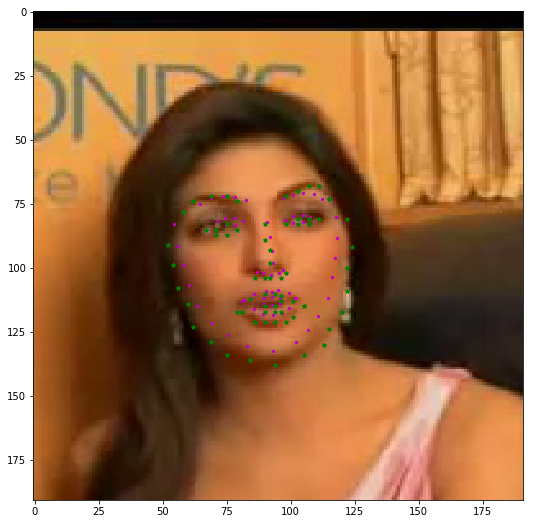

In [9]:
from data_load import FacialKeypointsDataset

# Plot in separate interactive figures
# %matplotlib notebook 

#data_transform = transforms.Compose([])
data_transform = None

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

# print length of test dataset
print('Length of test data set: {}'.format(len(test_dataset)))

# Randomly pick a few of the images from the test dataset
num_to_test = 3

for i in range(num_to_test):
        
    # randomly select a sample
    random_idx = np.random.randint(0, len(test_dataset))
    test_image = test_dataset[random_idx]['image']
    gt_key_pts = test_dataset[random_idx]['keypoints']
    
    # detect face bouding boxes in the given test image
    test_image_with_detections, faces = detect_faces(test_image)
    
    # predict facial keypoints in all proposed face bounding box detections
    predicted_key_pts_for_all_faces = predict_facial_keypoints(test_image, test_image_with_detections, faces)
        
    # compare predicted and grount truth keypoints with one another
    print('\nCompare ground truth key points with predicted key points:\n')
    print('{:<20} | {:<20} | {:<20}'.format('Keypoint index', 'Ground truth', 'Prediction'))
    for idx in range(68):
        print('{:<20} | [{:<8.3f}, {:<8.3f}] | [{:<8.3f}, {:<8.3f}]'.format(idx,
                                                                           gt_key_pts[idx,0],
                                                                           gt_key_pts[idx,1],
                                                                           predicted_key_pts_for_all_faces[0][idx,0],
                                                                           predicted_key_pts_for_all_faces[0][idx,1]))
    
    # plot predicted facial keypoints with ground truth keypoints in one image
    show_face_with_all_keypoints(test_image, 
                                 predicted_key_pts=predicted_key_pts_for_all_faces[0], 
                                 gt_pts=gt_key_pts)